In [3]:
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt
from typing import List

In [5]:
# Date parameters
start_date = "2018-01-01"
end_date = "2022-12-31"

# Assets for download
symbols = ["SPY", "CORN", "GLD", "USO", "WEAT"]

# Download the data
prices = yf.download(symbols, start=start_date, end=end_date)['Adj Close']

# Remove any columns with all NA values
prices = prices.dropna(axis=1, how='all')

# Update symbols list to only include available data
symbols = prices.columns.tolist()

print("Available symbols:", ", ".join(symbols))

[*********************100%***********************]  5 of 5 completed

Available symbols: CORN, GLD, SPY, USO, WEAT


In [7]:
# List of columns to normalize
columns_to_normalize = ['SPY','CORN', 'GLD', 'USO', 'WEAT']

normalized_prices = pd.DataFrame()
# Normalize specified columns to 100
for column in columns_to_normalize:
    max_value = prices[column].max()
    normalized_prices[f'{column}'] = round((prices[column] / max_value) * 100, 2)

In [9]:
def plot_time_series(df: pd.DataFrame, value_columns: List[str]) -> None:
    """
    Create a time series plot for specified columns in a DataFrame.
    Args:
    df (pd.DataFrame): The DataFrame containing the data.
    date_column (str): The name of the column containing date values.
    value_columns (List[str]): A list of column names to plot against the date.
    
    Returns:
    None: Displays the plot.
    """
    # Plotting
    plt.figure(figsize=(12, 6))
    for column in value_columns:
        if column not in df.columns:
            raise ValueError(f"Column '{column}' does not exist in the DataFrame.")
        plt.plot(df.index, df[column], label=column)
    
    plt.title('Time Series Plot')
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.legend()
    plt.grid()
    plt.show()

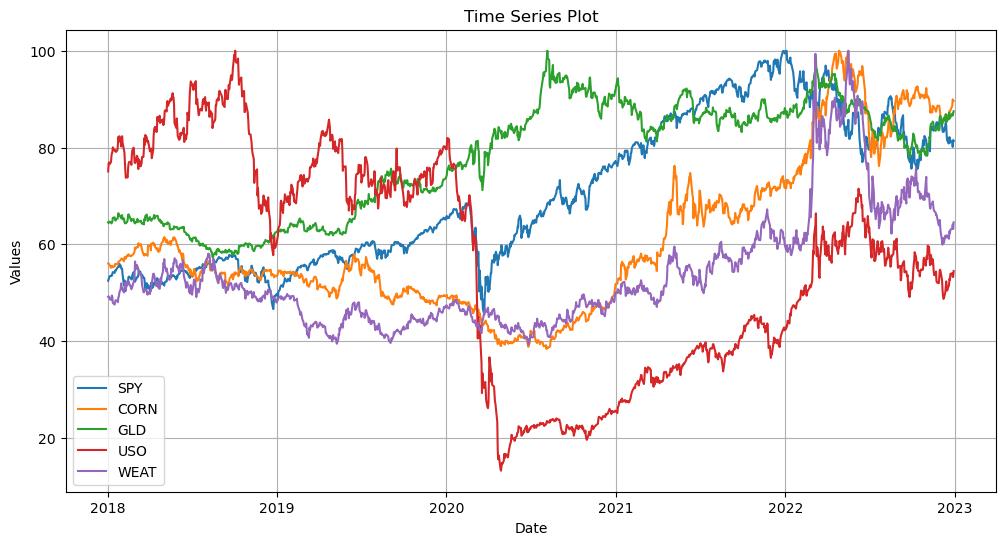

In [11]:
# Call the function to plot
plot_time_series(normalized_prices, value_columns=['SPY', 'CORN', 'GLD', 'USO', 'WEAT'])

In [331]:
# Compute daily returns
returns = np.log(prices / prices.shift(1)).dropna()

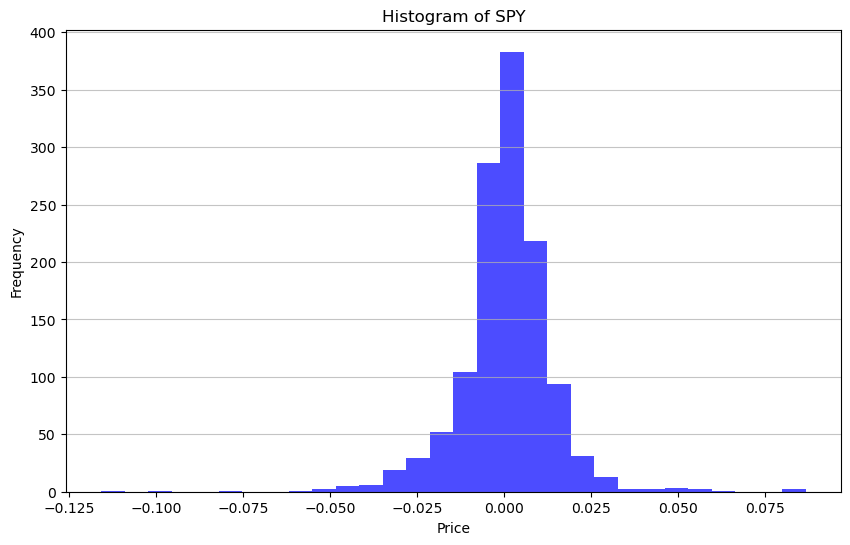

In [333]:
# Create a histogram of the SPY data
plt.figure(figsize=(10, 6))
plt.hist(returns['SPY'], bins=30, color='blue', alpha=0.7)
plt.title('Histogram of SPY')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [335]:
returns.describe()

Ticker,CORN,GLD,SPY,USO,WEAT
count,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000
mean,0.000373,0.000242,0.000348,-0.000254,0.000216
std,0.013255,0.009054,0.013633,0.028516,0.018748
min,-0.064538,-0.055190,-0.115887,-0.291891,-0.100126
25%,-0.006303,-0.004334,-0.005143,-0.011494,-0.010577
50%,0.000000,0.000520,0.000767,0.001612,0.000000
75%,0.007241,0.005078,0.007087,0.013581,0.010290
max,0.067853,0.047390,0.086731,0.154151,0.145041


In [316]:
# Define the event windows
T1w1, T2w1 = "2018-11-01", "2018-11-10"  # Replace with actual values
T1w2, T2w2 = "2020-01-10", "2020-01-20"  # Replace with actual values
T1w3, T2w3 = "2022-02-19", "2022-02-29"  # Replace with actual values

event_windows = [(T1w1, T2w1), (T1w2, T2w2), (T1w3, T2w3)]

# U.S.-China Trade War: (Starts of Tarrifs), (phase one trade deal) or Russia Ukraine WAR 
events_dates = ["2018-11-06", "2020-01-15", "2022-02-24"]

# Estimation period
N = 120  # Replace with actual value
estimation_period = N

# Display the results
print("Event Windows:", event_windows)
print("Estimation Period:", estimation_period)

Event Windows: [('2018-11-01', '2018-11-10'), ('2020-01-10', '2020-01-20'), ('2022-02-19', '2022-02-29')]
Estimation Period: 120


In [512]:
def calculate_car_and_t_stat(market_return, asset_return, event_window, estimation_window, event_date):
    event_start, event_end = event_window 
    est_win_start, est_win_end = estimation_window  # 'estimation_window'
    # A pandas DataFrame
    est_data = pd.DataFrame({'market': market_return[est_win_start: est_win_end], 
        'asset': asset_return[est_win_start: est_win_end]})
    # Perform OLS regression
    model = sm.OLS(est_data['asset'], sm.add_constant(est_data['market'])).fit()
    # Print the summary of the regression results
    const, coef = model.params[0], model.params[1]
    # Calculate residuals
    residuals = model.resid
    # Calculate standard error
    se = np.sqrt(np.sum(residuals**2) / (len(est_data) - 2)) * np.sqrt(1 + 1 / len(est_data) + 
        ((est_data['market'].loc[event_start: event_end] - est_data['market'].mean())**2).sum() / 
        ((est_data['market'] - est_data['market'].mean())**2).sum()) 
    # Calculate t-statistic for the CAR
    car = (asset_return.loc[event_start: event_end] - (const + coef * market_return.loc[event_start: event_end])).sum()  # Fixed 'returns' to 'asset_return' and 'market_return'
    t_stat = car / (se * np.sqrt(len(est_data)))
    # Expected return
    expected_returns = const + coef * market_return.loc[event_start: event_end]  # Fixed 'returns' to 'market_return'
    # Actual return
    actual_returns = asset_return.loc[event_start: event_end]  # Fixed 'returns' to 'asset_return'
    abnormal_returns = (actual_returns - expected_returns)
    # Cumulative Abnormal returns
    car = abnormal_returns.sum()
    return {'CAR': car, 'T-Statistics': t_stat, 'Event Date': event_date}

In [567]:
assets = ['CORN', 'WEAT', 'USO','GLD']

results = dict()
for asset in assets:
    result = calculate_car_and_t_stat(returns['SPY'], returns[asset], event_window = ("2022-02-19", "2022-03-01"),
                                      estimation_window =("2021-10-10", "2022-02-18"), event_date = events_dates[2])
    results[asset] = result

for asset, dictionary in results.items():
    car, tstat, event_date = dictionary.items()
    print(f'{asset}-> {car}, {tstat}, {event_date}')

CORN-> ('CAR', 0.07199242283775283), ('T-Statistics', 0.6838268473390662), ('Event Date', '2022-02-24')
WEAT-> ('CAR', 0.2014038592229073), ('T-Statistics', 1.2547099889555062), ('Event Date', '2022-02-24')
USO-> ('CAR', 0.10059348665924953), ('T-Statistics', 0.522964528878321), ('Event Date', '2022-02-24')
GLD-> ('CAR', 0.019981503578553564), ('T-Statistics', 0.2705387444736372), ('Event Date', '2022-02-24')


C:\Users\ismai\AppData\Local\Temp\ipykernel_9952\3667420885.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  const, coef = model.params[0], model.params[1]
C:\Users\ismai\AppData\Local\Temp\ipykernel_9952\3667420885.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  const, coef = model.params[0], model.params[1]
C:\Users\ismai\AppData\Local\Temp\ipykernel_9952\3667420885.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  con

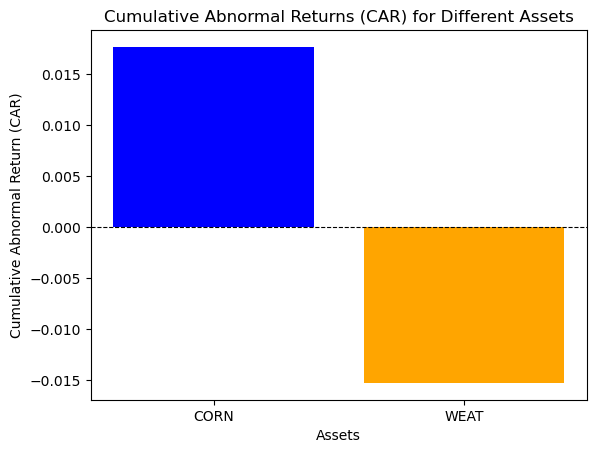

In [17]:
import matplotlib.pyplot as plt

# Sample data for CAR values of different assets
assets = ['CORN', 'WEAT']
car_values = [0.0177, -0.0153]  # Example CAR values for each asset

# Create a bar graph
plt.bar(assets, car_values, color=['blue', 'orange'])

# Adding titles and labels
plt.title('Cumulative Abnormal Returns (CAR) for Different Assets')
plt.xlabel('Assets')
plt.ylabel('Cumulative Abnormal Return (CAR)')

# Show the plot
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')  # Add a line at y=0 for reference
plt.savefig(fname='event_1.jpg')
plt.show()